In [8]:
#!pip install wrds
import psycopg2 
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas_datareader.data as web

def get_factors(factors='CAPM',freq='daily'):   
    
    if freq=='monthly':
        freq_label=''
    else:
        freq_label='_'+freq


    if factors=='CAPM':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
    
     
        df_factor = daily_data[['RF','Mkt-RF']] 
    elif factors=='FF3':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
    elif factors=='FF5':

        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')    
        
    else:
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')   
        fama_french = web.DataReader("F-F_Momentum_Factor"+freq_label, "famafrench",start="1921-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')
        df_factor.columns=['RF','Mkt-RF','SMB','HML','RMW','CMA','MOM']    
    if freq=='monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp())
    else:
        df_factor.index = pd.to_datetime(df_factor.index)
        


    return df_factor/100

# Characteristic-Based Trading strategies




---
**🎯 Learning Objectives**

1. **Contrast timing vs. cross-sectional approaches**  
   Recognize that characteristic-based strategies keep aggregate market exposure roughly constant and instead shift weight across individual stocks according to firm-level signals.

2. **Master the four-step portfolio recipe**  
   *Build a signal* → *sort stocks each month* → *weight within buckets (equal or market-cap)* → *form the long-short spread (top – bottom)*, always using information that is known on the trade date.

3. **Construct the market-cap-weighted benchmark correctly**  
   Compute market capitalizations from lagged price × shares-outstanding and show how to aggregate them to the total-market portfolio, avoiding look-ahead bias.

4. **Organize large equity data sets efficiently**  
   Work with “stacked” (date-firm) data frames, merge CRSP returns with characteristics, and reshape the grouped returns so they are ready for analysis and plotting.

5. **Code a reusable function that maps any signal to portfolios**  
   Generalize the recipe into a single function that takes a signal (`X`), number of groups, and weighting choice, and then delivers decile returns, cumulative-return plots, and the long-short series.

6. **Develop empirical intuition about trade-offs**  
   Explore how the number of groups, the dispersion of the signal, and the choice of weights influence the return spread, volatility, and diversification of the resulting portfolios.



---






* So far we have looked at strategies that go in and out of a particular asset according to a signal. 

* We looked at past average returns, past  volatility, and past co-variances

* Now we will look at strategies that trade of asset characteristics

* A characteristic is anything that you can associate to a particular stock

* Past average returns, past volatility are types of charateristics

* but it is much more general than that



**The  recipe**

1. Construct a characteristic for each stock. 
    - It can be based on accounting data, return data, textual data from earning calls, twitter activity, ownership, shorting activity, satellite images--
    - You can do for anything 
    - What is important is that for each stock in each date you have a value for this characteristic
    
    
2. On a given date sort stocks by this characteristic. 
    - It is key that this characteristic is in fact known at sorting date!
    - Extremely careful not to introduce "look-ahead" bias
    
3. Construct portfolios by dividing stocks in deciles/quintiles and form portfolios of stocks that have similar characteristic
    - You can either equal weight or value weight within portfolio
    - Value-weighed portfolios are easier to trade, but if you are focused on large caps, you can go with either
    - But what is important is that each portfolio will have stocks of have very different characteristic values
    
4. Construct the long-short where you go long portfolio 10 and short portfolio 1 (or vice versa) but the point is to take a bet on the characteristic spread 


>**But the goal here is to produce alpha**
> - this is a simply and algorithimic  way to implement your idea in a way that harvest the benefits of diversification
> - Instead of betting on Tesla because Musk is close to trump, build a trump connection "characteristic"
> - How exactly? Now sure...but I am sure someone is thinking...
>- What are potential characteristcs that might be interesting right now in 2025 with a new administration?


**From "names"  to characteristics**

* The  sorting by date keeps the stocks inside the portfolios with similar characteristics
* This sorting will "work" if these chracteristics are good proxies for the behavior of the stock returns 
* Indeed, the key is that each portfolio has stocks of vastly different characterisitcs and keeps churning as firms change
  * Let's take MSFT (microsoft) as an example:
  * MSFT transitioned from being small in the 80's to be gigantic in the 90's, as a result, it moved up from the small portfolio to the big portfolio
  * During the Tech boom when MSFT had a huge valuation relative to it's book value, it went to the low BM portfolio
  * But then MSFT transtioned back to the high BM portfolio once it's market valuation collapsed in the aftermath of the techbubble
  * Now with AI, MSFT is back into the low BM portfolio
  * During these 80 years MSFT changed dramatically and the characteristic changed with it...

* The key is that firms' characteristics change over time, by constructing  portfolios, we hope to estimate some stable parameters (for example, alpha and beta)

* But it doesn't work always, if you use the first letter of stock ticker to construct 26 portfolios you are unlikely to get spread in average returns and most likely each portfolio will resemble the market portfolio but with much more volatility.

>### Large Data
>* We will now work with large data sets
>* Data sets that include all US stocks
>* Because there are many stocks, we have to work with it stacked
>* As a warm up for you first factor construction we will construct the returns on the market portfolio

## The Market-Cap Weighted strategy


* start with a vector of market capitalization for all relevant assets $M_t=[m_t^{AAPL},m_t^{GOOG},m_t^{TSLA},..]$ 

$$m_t^{AAPL}=P^{AAPL}_t\times SharesOutstanding^{AAPL}$$

The strategy then set the weights simply to 

$$X_t=\frac{M_t}{\sum_i^Im^i_t}$$

So at end of month **t** you look at the market caps, construct the weights, and buy the assets with weights $X_t$ to earn

$$R^{mcap}_{t+1}=X_tR_{t+1}$$

at the end of the next month.

This portfolio has nice properties

1. This portfolio is very easy to trade. It does not require re-balancing as you weights naturally go up if the stock rallies and go down if the stock crashes
  
2. You can implement this approach to any subset of firms (for example SP500 or Russel2000) are market cap indexes that track a particular universe of stocks and we will be using it in our characteristic-based portfolios shortly

3. By buying proportionally to market cap you never have to build a huge position in a tiny stock


>**Steps**
>1. Get firm level monthly return data with market capitalizations
>2. clean up/organize the data set
>3. Make sure to lag the market cap signal so that we use prices from last month to trade at the start of this month ( we could also skip another month to be extra sure)
>4. Construct the weighted average of returns across stocks for each date

**Organizing the data**

The objective here is to have a data set with 

- Security identifier
- Date of the information
- Monthly return of the firm in that month
- Market capitalization of the firm in that month

In [10]:
conn=wrds.Connection() 

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [11]:
import datetime as dt

from dateutil.relativedelta import *
from pandas.tseries.offsets import *

###################



crsp = conn.raw_sql("""
                      select a.permno,a.permco, a.date, b.shrcd, b.exchcd,b.ticker,
                      a.ret, a.shrout, a.prc,a.retx
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/31/2002' and '12/31/2016'
                      and b.exchcd between 1 and 3
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 


# this saves it
crsp.to_pickle('../../assets/data/crspm20022016.pkl')
# variables downloaded

# 1. Permno-- are unique indentifier to a security 
# (for exmaple a stock that has multiple types of stocks will have multiple permnos)

# 2. shrco is the type of share: common share, ADR, ETF, ....
# we will focus on common shares

# 3. exchcd is the code of the exchange where the stock was originally listed
# we will focus on stock listed in the 3 major stock exchanges ( basically the whole market)

# 4. ret,retx, shrout,  prc, are the stock return, the stock return excluding dividends, number of shares outstanding, and price

# 5. date is the trading date of the return



____
*If you don't want to deal with that you can simply get the data by running the code below*

In [ ]:

crsp=pd.read_pickle('https://github.com/amoreira2/Fin418/blob/main/assets/data/crspm20022016.pkl?raw=true')

In [12]:
from pandas.tseries.offsets import *
crsp=crsp[['permco','permno','ticker','date','ret','shrout','prc']].copy()
# change variable format to int
crsp[['permno']]=crsp[['permno']].astype(int)
crsp[['permco']]=crsp[['permco']].astype(int)
# Line up date to be end of month 
crsp['date']=crsp['date']+MonthEnd(0)

# calculate market equity
# why do we use absolute value of price?
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
# drop price and shareoustandng since we won't need it anymore
crsp=crsp.drop(['prc','shrout'], axis=1)
crsp_me=crsp.groupby(['date','permco'])['me'].sum().reset_index()


# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['date','permco'])['me'].max().reset_index()

# join by jdate/maxme to find the permno
crsp=pd.merge(crsp, crsp_maxme, how='inner', on=['date','permco','me'])

# drop me column and replace with the sum me
crsp=crsp.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info
crsp=pd.merge(crsp, crsp_me, how='inner', on=['date','permco'])

# sort by permno and date and also drop duplicates
crsp=crsp.sort_values(by=['permno','date']).drop_duplicates()

crsp.head()

,permco,permno,ticker,date,ret,me
550,7953,10001,EWST,2002-01-31,-0.013100,28995.8000
551,7953,10001,EWST,2002-02-28,-0.053097,27488.3000
552,7953,10001,EWST,2002-03-31,-0.015888,26738.4000
553,7953,10001,EWST,2002-04-30,-0.043269,25581.4500
554,7953,10001,EWST,2002-05-31,0.014824,25960.6725


> ### Take time to note the stacked structure of the data set
>-  Before with a "rectangular" data set  we need two coordinates, row and column, to identify the return of an asset in a particular date
> - It was easier to manipulate but we would need one dataframe for each different firm variable: In this case one for return and one for market equity
> - As we work with many signals, this becomes intractable because we would need many dataframes
> - As we work with many asset, this would become intractable because we would need dataframes with many columns with most locations empty. This is very inefficient and hard to manipulate
> ### Stacked data sets
> - Now we need two coordinates both in columns, "date" and "permco", to identify one firm-date observation, and then a third coordinate, the column names to identify the particular variable for that firm-date pair

In [19]:

crsp.iloc[705:725]

,permco,permno,ticker,date,ret,me
454,7976,10026,JJSF,2015-09-30,0.000527,2.122714e+06
455,7976,10026,JJSF,2015-10-31,0.080327,2.293226e+06
456,7976,10026,JJSF,2015-11-30,-0.049760,2.180282e+06
457,7976,10026,JJSF,2015-12-31,0.003257,2.179046e+06
458,7976,10026,JJSF,2016-01-31,-0.074484,2.017714e+06
459,7976,10026,JJSF,2016-02-29,0.026023,2.070222e+06
460,7976,10026,JJSF,2016-03-31,-0.019135,2.015849e+06
461,7976,10026,JJSF,2016-04-30,-0.066033,1.882939e+06
462,7976,10026,JJSF,2016-05-31,0.043212,1.964304e+06
463,7976,10026,JJSF,2016-06-30,0.134218,2.220569e+06


>**Lagging the market cap signal**
>
>- We use the method `.shift(d)` which "lags" the data by d periods.
>- It is important that we have our data set sorted by date
>- ``shift(d)`` simply shifts the rows. So you have to make sure that it is actually lagging by date. 
>
>The way to do that is to  `groupby` security and applying the shift within security.

>Why this is important?
>- Because the data set is stacked so when you shift the first month of security n, it will end up returning the last month of security n-1.
>- By "grouping by" we correctly assign a missing value there since we don't have the data

In [16]:
# sort by permno and date and set as index
crsp=crsp.sort_values(by=['permno','date'])

In [21]:
# done incorrectly
crsp['me_l1']=crsp.me.shift(1)
crsp.iloc[705:725]
# what is the problem  here?

,permco,permno,ticker,date,ret,me,me_l1
454,7976,10026,JJSF,2015-09-30,0.000527,2.122714e+06,2.130938e+06
455,7976,10026,JJSF,2015-10-31,0.080327,2.293226e+06,2.122714e+06
456,7976,10026,JJSF,2015-11-30,-0.049760,2.180282e+06,2.293226e+06
457,7976,10026,JJSF,2015-12-31,0.003257,2.179046e+06,2.180282e+06
458,7976,10026,JJSF,2016-01-31,-0.074484,2.017714e+06,2.179046e+06
459,7976,10026,JJSF,2016-02-29,0.026023,2.070222e+06,2.017714e+06
460,7976,10026,JJSF,2016-03-31,-0.019135,2.015849e+06,2.070222e+06
461,7976,10026,JJSF,2016-04-30,-0.066033,1.882939e+06,2.015849e+06
462,7976,10026,JJSF,2016-05-31,0.043212,1.964304e+06,1.882939e+06
463,7976,10026,JJSF,2016-06-30,0.134218,2.220569e+06,1.964304e+06


In [23]:

crsp['me_l1']=crsp.groupby(['permno']).me.shift(1)
crsp.iloc[705:725]
# did it get fixed?

,permco,permno,ticker,date,ret,me,me_l1
454,7976,10026,JJSF,2015-09-30,0.000527,2.122714e+06,2130938.040
455,7976,10026,JJSF,2015-10-31,0.080327,2.293226e+06,2122714.160
456,7976,10026,JJSF,2015-11-30,-0.049760,2.180282e+06,2293226.040
457,7976,10026,JJSF,2015-12-31,0.003257,2.179046e+06,2180282.480
458,7976,10026,JJSF,2016-01-31,-0.074484,2.017714e+06,2179045.590
459,7976,10026,JJSF,2016-02-29,0.026023,2.070222e+06,2017714.280
460,7976,10026,JJSF,2016-03-31,-0.019135,2.015849e+06,2070221.940
461,7976,10026,JJSF,2016-04-30,-0.066033,1.882939e+06,2015848.760
462,7976,10026,JJSF,2016-05-31,0.043212,1.964304e+06,1882939.470
463,7976,10026,JJSF,2016-06-30,0.134218,2.220569e+06,1964304.500


In [25]:
Rmkt=crsp.groupby(['date']).apply(lambda x:(x.ret*(x.me_l1/x.me_l1.sum())).sum(),include_groups=False)

>- The `groupby(['date'])` method groups the data by month so we obtain the return of the portfolio in that month
>-  `(x.me/x.me.sum())` has the weights in a given date, which for each date will return a vector that adds up to one. 
>-  `(x.ret*(x.me/x.me.sum())` multiplies the return of each asset by the weight 
>- ``(x.ret*(x.me/x.me.sum())).sum()``  sum all up to get the reutrn of the portfolio




Lets compare our factor with the one ken french website

c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)
c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)


<Axes: xlabel='Date'>

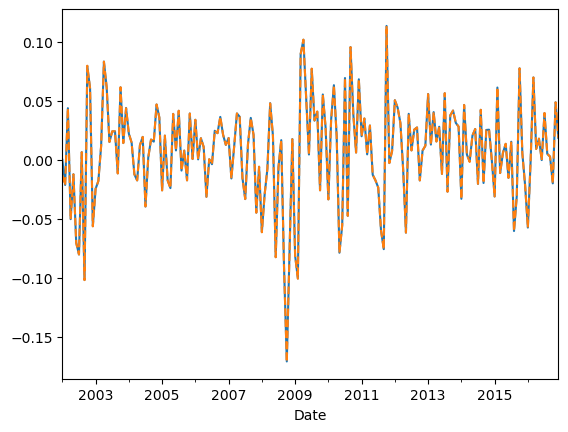

In [26]:
#Lets look at the cumulative return
df=get_factors('CAPM',freq='monthly')

(Rmkt).plot()
(df['Mkt-RF']+df['RF'])['2002':'2016'].plot(linestyle='dashed')

**Things to try**

- Suppose you wanted to construct something "like" the SP500? I.e. do market cap weights but only for the 500 largest firms in a given month. How would you do that?
- Suppose you lag market cap 2 months instead of 1 does it make any difference? Do you expect there is any difference
- Suppose you drop the stocks with "negative" prices, does it make a difference?

## Factor Construction: Implementing the recipe

1. We will start with a constructed characteristic $c_{i,t}$
2. Produce 10 portfolios based on this characteristic
    - Members of portfolio 1 in date t have the bottom 10% value of the characteristics in date t
    - Members of portfolio 2 in date t have characteristic between 10% and 20% of the characteristics in date t
3. Given these memberships for each date we will the construct return by buying at the closing price of date t and selling at the closing on date t+1
    - We will typically work with monthly data, so this should read as the closing of the last date of months t and t+1
   

In [27]:
url = "https://github.com/amoreira2/Fin418/blob/main/assets/data/characteristics20022016.pkl?raw=true"

df_X = pd.read_pickle(url)
df_X=df_X.reset_index()
df_X.date=df_X.date+pd.tseries.offsets.MonthEnd()

In [29]:
crsp_merged=crsp.merge(df_X,how='inner',on=['date','permno'])
crsp_merged

,permco,permno,ticker,date,ret,me,me_l1,re,rf,rme,...,momrev,valuem,nissm,strev,ivol,betaarb,indrrev,price,age,shvol
0,7976,10026,JJSF,2015-10-31,0.080327,2.293226e+06,2.122714e+06,0.080327,0.0000,0.0775,...,0.026234,-1.235953,0.693495,0.000527,0.010276,0.979836,0.019387,4.733212,5.880533,0.547529
1,7976,10026,JJSF,2015-11-30,-0.049760,2.180282e+06,2.293226e+06,-0.049760,0.0000,0.0056,...,-0.018624,-1.283899,0.693495,0.080327,0.007560,0.980258,0.024293,4.810476,5.883322,0.549169
2,7976,10026,JJSF,2016-01-31,-0.074484,2.017714e+06,2.179046e+06,-0.074584,0.0001,-0.0577,...,0.121467,-1.232827,0.693120,0.003257,0.011044,0.972599,-0.024166,4.759349,5.888878,0.543436
3,7976,10026,JJSF,2016-02-29,0.026023,2.070222e+06,2.017714e+06,0.025823,0.0002,-0.0007,...,0.151384,-1.200693,0.693094,-0.074484,0.011646,0.966853,-0.062979,4.681946,5.891644,0.577112
4,7976,10026,JJSF,2016-03-31,-0.019135,2.015849e+06,2.070222e+06,-0.019335,0.0002,0.0696,...,0.092101,-1.168166,0.693094,0.026023,0.008756,0.958969,0.007363,4.707637,5.894403,0.580431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163360,53453,93436,TSLA,2016-08-31,-0.097023,3.164016e+07,3.491163e+07,-0.097223,0.0002,0.0050,...,0.187434,-3.467612,0.774498,0.106039,0.023503,1.202041,0.016793,5.458691,4.330733,2.039172
163361,53453,93436,TSLA,2016-09-30,-0.037640,3.056879e+07,3.164016e+07,-0.037840,0.0002,0.0025,...,0.267903,-3.484510,0.765204,-0.097023,0.020798,1.216683,-0.092388,5.356633,4.343805,1.908743
163362,53453,93436,TSLA,2016-10-31,-0.030878,2.963795e+07,3.056879e+07,-0.031078,0.0002,-0.0202,...,0.202814,-3.450063,0.762938,-0.037640,0.015124,1.225626,-0.034816,5.318267,4.356709,1.724083
163363,53453,93436,TSLA,2016-11-30,-0.042128,2.840318e+07,2.963795e+07,-0.042228,0.0001,0.0486,...,0.274511,-3.419139,0.762969,-0.030878,0.016082,1.251558,0.001584,5.286902,4.369448,1.792732


In [30]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(crsp_merged.describe().T)

,count,mean,min,25%,50%,75%,max,std
permco,163365.0,20298.65372,7.0,10657.0,20561.0,24345.0,54638.0,13219.775632
permno,163365.0,60414.817403,10026.0,35167.0,73139.0,84129.0,93436.0,27276.949546
date,163365,2009-07-16 00:19:52.617758208,2002-01-31 00:00:00,2005-10-31 00:00:00,2009-06-30 00:00:00,2013-03-31 00:00:00,2016-12-31 00:00:00,NaN
ret,163365.0,0.009015,-0.868645,-0.039067,0.010025,0.057652,1.598007,0.094329
me,163365.0,14220771.14716,182907.67,2494377.6,4492401.0,11627819.34,750709577.84,32887588.091769
me_l1,162550.0,14167493.57439,808087.32,2480508.3,4466405.195,11576256.8375,750709577.84,32774756.047214
re,163365.0,0.007986,-0.870345,-0.040201,0.008928,0.056658,1.597907,0.094384
rf,163365.0,0.001033,0.0,0.0,0.0002,0.0015,0.0044,0.001368
rme,163365.0,0.005873,-0.1723,-0.0183,0.0092,0.0323,0.1135,0.041749
size,163365.0,15.551836,11.501877,14.676478,15.295781,16.241431,20.388632,1.161892


### What are these characteristics?

- They are based on various accounting and market based information
- For detailed description see pages of 
- Each characteristic is constructed differently--we will discuss in detail a handful of them
- But the characteristics signals we have here are equal to cross-sectional ranks of a given stock's characteristic, centered, and normalized by the sum of absolute values of all ranks in the cross section.
  $$\frac{c_{i,t}-\overline{c}_t}{\sum_i|c_{i,t}-\overline{c}_t|}$$

>- For what we are doing here this does not matter at all. Our sorting procedure is already defacto doing that 
>- This will matter if we use these characteristics to run regressions directly--more on this soon




**Group assets by signal**


*  We select our characteristic

* We now need to assign groups to each stocks. These groups will identify which portfolio each stock belongs in a particular date according to the position of the characteristic in that date

* We will do this by applying the function [pd.qcut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html)  to the chosen characteristic. This will "cut" the signal distribution in the chosen number of groups. 

* The important aspects is that we will applying this date by date. This make the strategy cross-sectional because you are using the distribution of the signal as given date to the grouping-- Very much like curved grades by cohort

* Details
   - `duplicates='drop'`: In case there are two stocks with exactly the same signal that are exactly in the cutoff of the groups, we drop one of the observations 
   - ` labels=False`: The method simply label the groups with numbers. For example if `ngroups=10` then it will assign `0` to the stocks with the  bottom 10% returns in a given date, `1` to stocks with returns in between 10% and 20% of the signal distribution on a given date, ..., and 9 for stocks in the top 10% (signal in between 90% and 100% of the return distribution on a given date) .
   

In [31]:
X='value'

ngroups=10
crsp_merged['X_group']=crsp_merged.groupby(['date'])[X].transform(lambda x: pd.qcut(x, ngroups, labels=False,duplicates='drop'))
crsp_merged[['date','permco','ticker',X,'X_group']]

,date,permco,ticker,value,X_group
0,2015-10-31,7976,JJSF,-1.207554,4
1,2015-11-30,7976,JJSF,-1.207554,4
2,2016-01-31,7976,JJSF,-1.207554,4
3,2016-02-29,7976,JJSF,-1.207554,4
4,2016-03-31,7976,JJSF,-1.207554,4
...,...,...,...,...,...
163360,2016-08-31,53453,TSLA,-3.328269,0
163361,2016-09-30,53453,TSLA,-3.328269,0
163362,2016-10-31,53453,TSLA,-3.328269,0
163363,2016-11-30,53453,TSLA,-3.328269,0


>**Portfolio formation tradeoffs: Diversification vs Signal Strengh**
>* We will start by constructing Equal weighted portfolios within each signal bucket
>* Why not sort in 100 groups instead on only 10? This way your top portfolio would have much higher average characteristics
>* Why no simply focus on the stock with the highest characteristic?

>  1. Individual stocks have $\sigma$ = 40 − 80%, so $\sigma/\sqrt{T}$ makes it nearly impossible to accurately measure E(R). Portfolios have lower $\sigma$ by diversification.
>  2. So  you have to trade-off strengh of the signal against benefits of diversification

**Calculate the portfolio return**

We will do market cap weights, but you could do Equal weight or even sginal weights

$$\sum_i^I w_{it} r_{it}$$

Where the weights must add up to 1.

Before forming portfolios we will use the risk-free rate so we form fully invested portfolios. So the ouput will be returns and not excess returns

**Equal weighted returns**

<Axes: xlabel='date'>

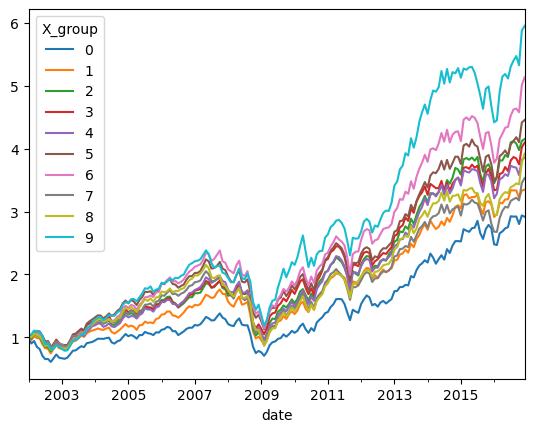

In [32]:

ret_byX_ew =crsp_merged.groupby(['date','X_group']).ret.mean()
ret_byX_ew=ret_byX_ew.unstack(level=-1)
(ret_byX_ew+1).cumprod().plot()

**Market cap weighted returns**

C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_18052\709199391.py:1: RuntimeWarning: invalid value encountered in scalar divide
  ret_byX_vw =crsp_merged.groupby(['date','X_group']).apply(lambda x:(x.ret*x.me_l1).sum()/x.me_l1.sum())
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_18052\709199391.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret_byX_vw =crsp_merged.groupby(['date','X_group']).apply(lambda x:(x.ret*x.me_l1).sum()/x.me_l1.sum())


<Axes: xlabel='date'>

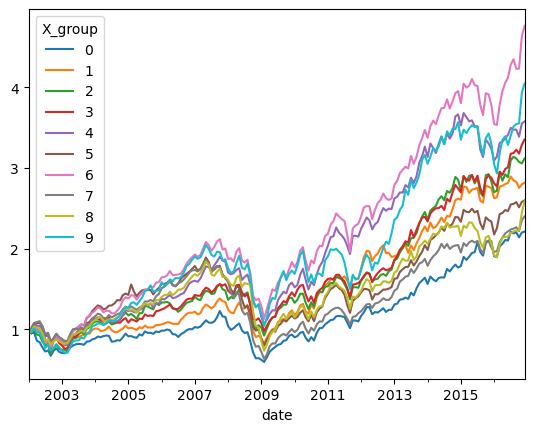

In [33]:

ret_byX_vw =crsp_merged.groupby(['date','X_group']).apply(lambda x:(x.ret*x.me_l1).sum()/x.me_l1.sum())
ret_byX_vw=ret_byX_vw.unstack(level=-1)
(ret_byX_vw+1).cumprod().plot()

If we focus on a particular stock, we can see how it's portfolio membership changed over time.

You can check you that some characteristics are fairly persistent and change only slowly over time

While others, like momentum change very frequently.

<Axes: xlabel='date'>

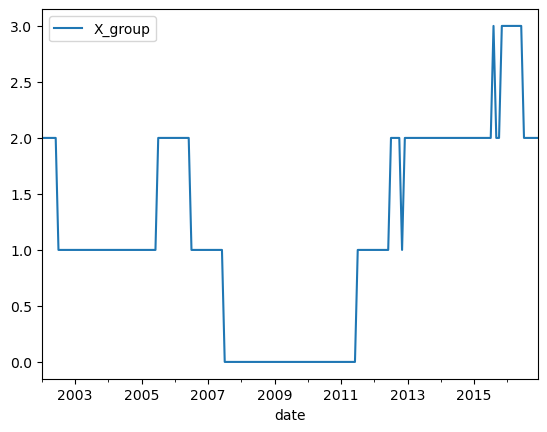

In [34]:
crsp_merged[crsp_merged.ticker=='MSFT'][['date','X_group']].plot(x='date',y='X_group')

> ### Wrapping all in a function that goes from the signal to the portfolio
> Things to try
> - Play with different number of groups, how the spread in X across portfolios change? How the volatility of the individual portfolios change?
> - Look at different characteristics. Which ones create higher spread in average returns
> - Construct the long-short portfolio that goes long the high portfolio and short the low portfolio. What are the properties of this portfolio?
> - Which ones have alpha relative to the market in the sample? What do their betas look like
> - When they perform poorly?
> - How correlated are the returns of the long-shorts of different characteristics?

C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_18052\3445167417.py:3: RuntimeWarning: invalid value encountered in scalar divide
  ret =df.groupby(['date','X_group']).apply(lambda x:(x[y]*x['me_l1']).sum()/x['me_l1'].sum())
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_18052\3445167417.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret =df.groupby(['date','X_group']).apply(lambda x:(x[y]*x['me_l1']).sum()/x['me_l1'].sum())


X_group,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2002-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-28,-0.053561,-0.039466,0.004963,-0.011140,0.008576,0.012135,-0.010474,-0.024351,-0.008889,-0.015949
2002-03-31,0.005538,0.040591,0.064328,0.023602,0.047272,0.031937,0.046027,0.054631,0.076157,0.077783
2002-04-30,-0.105371,-0.052429,-0.054811,-0.078009,-0.015114,-0.043753,-0.026744,-0.032535,-0.041836,0.011104
2002-05-31,-0.028019,-0.026982,0.001821,0.014756,0.019451,0.014131,-0.020531,-0.015612,-0.009811,0.011111
...,...,...,...,...,...,...,...,...,...,...
2016-08-31,0.001801,-0.011386,-0.006908,0.011154,-0.003089,-0.011194,-0.006691,-0.020183,0.007104,0.069210
2016-09-30,0.010313,-0.004204,0.007539,0.005398,-0.007480,0.007861,0.005350,0.021656,-0.002003,-0.026213
2016-10-31,-0.027826,-0.013372,-0.024505,-0.034533,-0.014934,-0.024761,-0.017477,-0.026599,-0.020499,0.038941


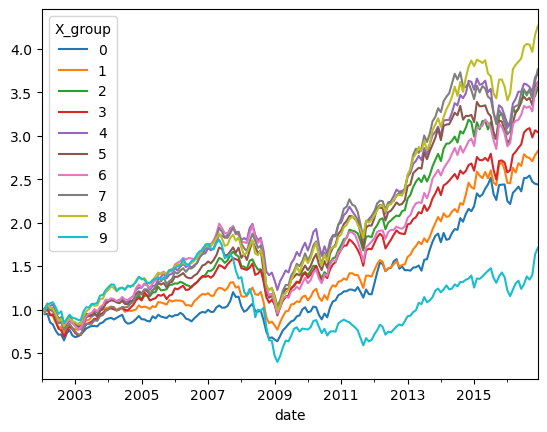

In [35]:
def returnbyX(df,y='ret',X='value',ngroups=10,plot=True):
    df['X_group']=df.groupby(['date'])[X].transform(lambda x: pd.qcut(x, ngroups, labels=False,duplicates='drop'))
    ret =df.groupby(['date','X_group']).apply(lambda x:(x[y]*x['me_l1']).sum()/x['me_l1'].sum())
    ret=ret.unstack(level=-1)
    if plot:
        if y=='ret':
            (ret+1).cumprod().plot()
        else:
            ret.plot()
    return ret


returnbyX(crsp_merged,y='ret',X='lev',ngroups=10,plot=True)




---
**📝 Key Takeaways**

- **Stacked data frames are the backbone** when working with thousands of stocks and multiple characteristics.  
- **Lagged market-cap weights should be the default**: they minimize turnover, reflect realistic trading capacity, and eliminate look-ahead bias.  
- **Characteristic-sorted portfolios isolate cross-sectional spreads** in the signal; the long-short “top minus bottom” position delivers a clean test of the signal’s pricing power.  
- **Portfolio design choices matter**: more groups widen the average-return spread but shrink the number of stocks per bucket; equal-weighting boosts the influence of small caps, while value-weighting is closer to how real money is run.  
- **A single, well-structured function automates experimentation** across different signals, making it easy to investigate which characteristics generate higher alpha, when they underperform, and how their long-short returns co-move.  
- **The core tension is signal strength versus diversification**: stronger signals often come with higher concentration and trading costs, so practical implementation always balances these forces.
---